In [5]:
import torch
from torch import nn
import os
from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau


class RetinaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)
        image = Image.open(img_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        # Genera le coordinate normalizzate per ogni pixel
        coords = np.meshgrid(np.linspace(-1, 1, image.shape[2]), np.linspace(-1, 1, image.shape[1]))
        coords = np.stack(coords, axis=-1)
        coords = torch.FloatTensor(coords)  # Converte in tensori di torch
        coords = coords.view(-1, 2)  # Flatten delle coordinate in [N, 2] dove N è il numero di pixel

        return coords, image.view(-1, 1), mask.view(-1, 1)

    
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=30):
        super().__init__()
        self.in_features = in_features 
        self.omega_0 = omega_0
        self.is_first = is_first
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                # Inizializza i pesi uniformemente nella prima posizione
                self.linear.weight.uniform_(-1 / self.in_features, 
                                            1 / self.in_features)
            else:
                # Inizializza i pesi per gli altri livelli
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                            np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SineLayer(in_features, hidden_features, is_first=True, omega_0=first_omega_0))

        for _ in range(hidden_layers):
            self.layers.append(SineLayer(hidden_features, hidden_features, omega_0=hidden_omega_0))

        self.final_layer = nn.Linear(hidden_features, out_features)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.final_layer(x)
    
def train(model, dataloader, optimizer, scheduler, epochs=5):
    model.train()
    for epoch in range(epochs):
        for coords, image, mask in dataloader:
            coords, image, mask = coords.to(device), image.to(device), mask.to(device)
            optimizer.zero_grad()
            outputs = model(coords)
            loss = nn.MSELoss()(outputs, mask)  # Calcola la perdita usando la maschera come target
            loss.backward()
            optimizer.step()
            scheduler.step(loss)  # Passa la perdita al scheduler
            print("Current learning rate:", scheduler.optimizer.param_groups[0]['lr'])
            print(f"Epoch {epoch}, Loss: {loss.item()}")





train_input = 'C:/Users/Q540900/Desktop/A.I. Master/Werkstudent/RAVIR Dataset/train/training_images'
train_output = 'C:/Users/Q540900/Desktop/A.I. Master/Werkstudent/RAVIR Dataset/train/training_masks'

transform = Compose([
    # Resize((768, 768)), #256
    ToTensor(),
    Normalize(mean=[0.4227], std=[0.1457])
])

train_dataset = RetinaDataset(train_input, train_output, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running on device:', device)
model = Siren(in_features=2, hidden_features=192, hidden_layers=3, out_features=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.8)

train(model, train_loader, optimizer, scheduler, epochs=30)

Running on device: cpu
Current learning rate: 0.001
Epoch 0, Loss: 6.973346710205078
Current learning rate: 0.001
Epoch 0, Loss: 9.949898719787598
Current learning rate: 0.001
Epoch 0, Loss: 7.628389358520508
Current learning rate: 0.001
Epoch 0, Loss: 5.6556196212768555
Current learning rate: 0.001
Epoch 0, Loss: 4.3277764320373535
Current learning rate: 0.001
Epoch 1, Loss: 4.658236980438232
Current learning rate: 0.001
Epoch 1, Loss: 3.7945003509521484
Current learning rate: 0.001
Epoch 1, Loss: 4.003964424133301
Current learning rate: 0.001
Epoch 1, Loss: 3.5805022716522217
Current learning rate: 0.001
Epoch 1, Loss: 3.8621349334716797
Current learning rate: 0.001
Epoch 2, Loss: 3.7190897464752197
Current learning rate: 0.001
Epoch 2, Loss: 3.8588948249816895
Current learning rate: 0.001
Epoch 2, Loss: 4.196431636810303
Current learning rate: 0.001
Epoch 2, Loss: 3.4591047763824463
Current learning rate: 0.001
Epoch 2, Loss: 3.4650332927703857
Current learning rate: 0.001
Epoch 3, 

In [6]:
torch.save(model.state_dict(), 'retina_segmentation_model.pth')

In [7]:
test_input = 'C:/Users/Q540900/Desktop/A.I. Master/Werkstudent/RAVIR Dataset/test'


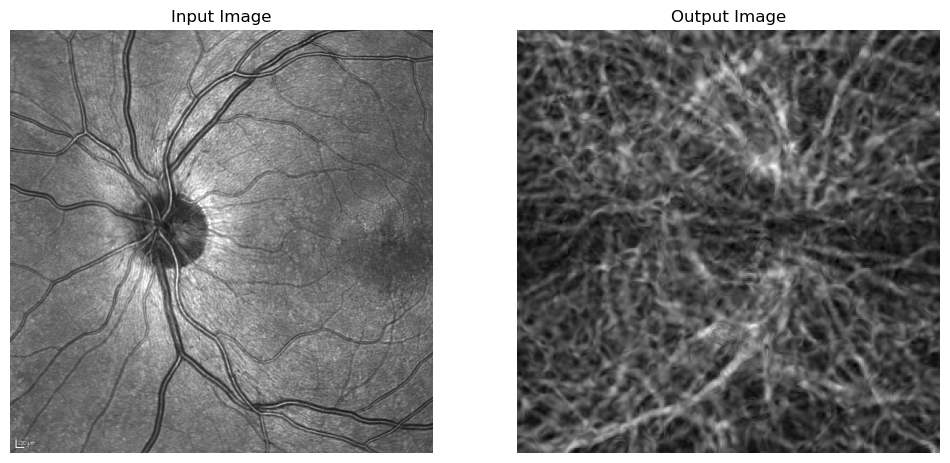

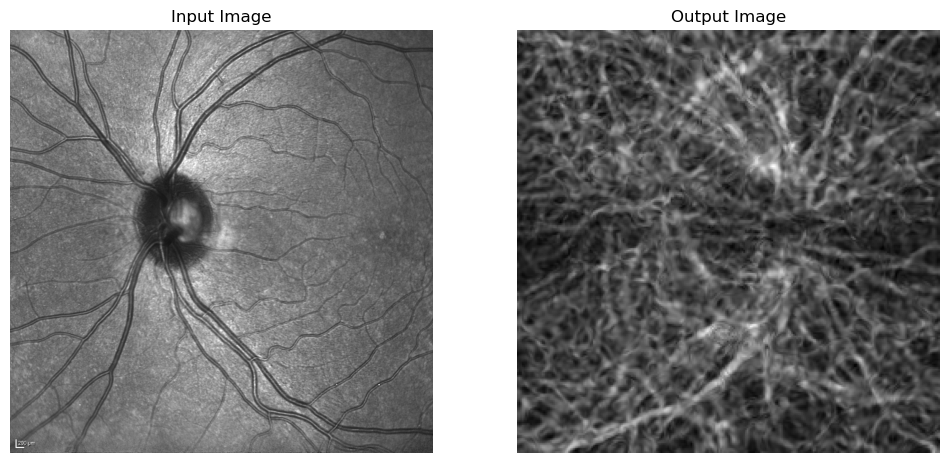

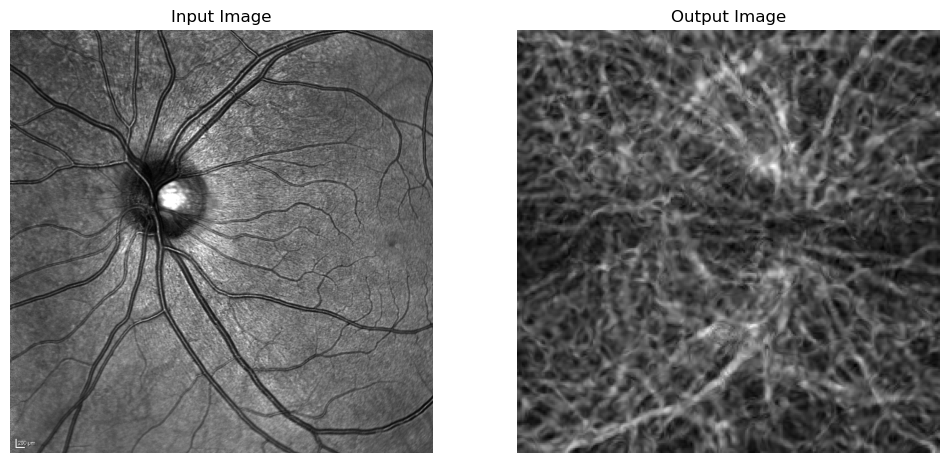

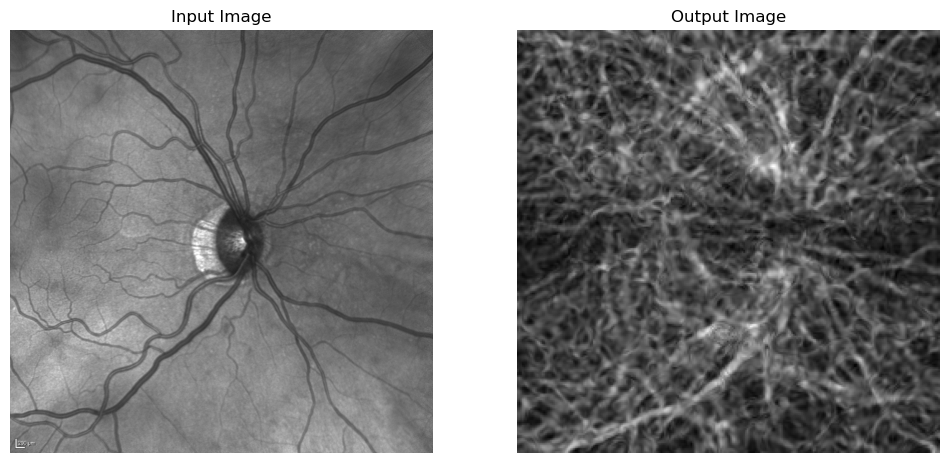

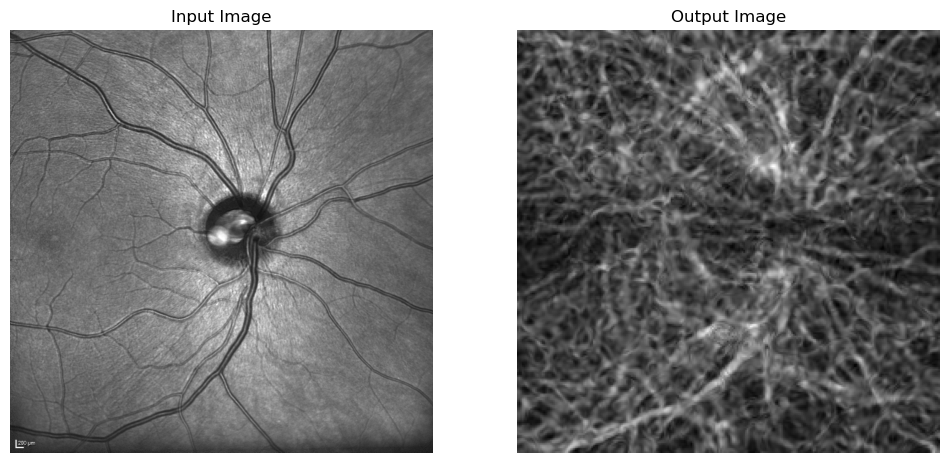

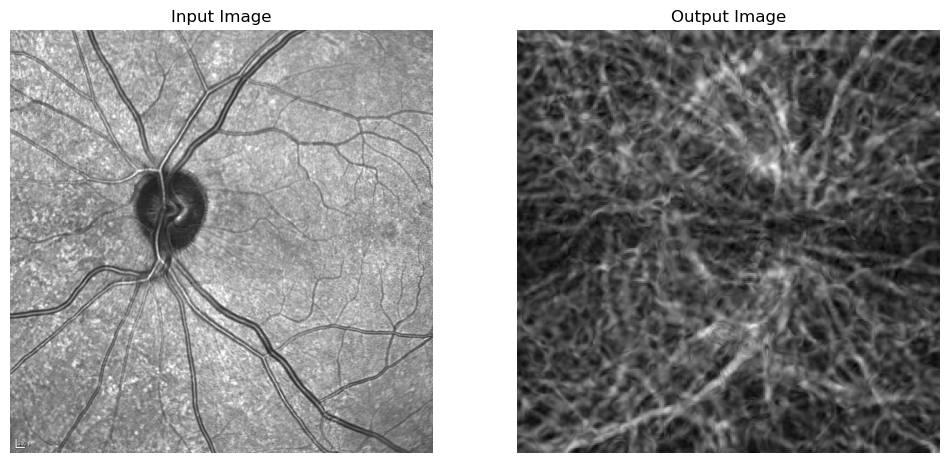

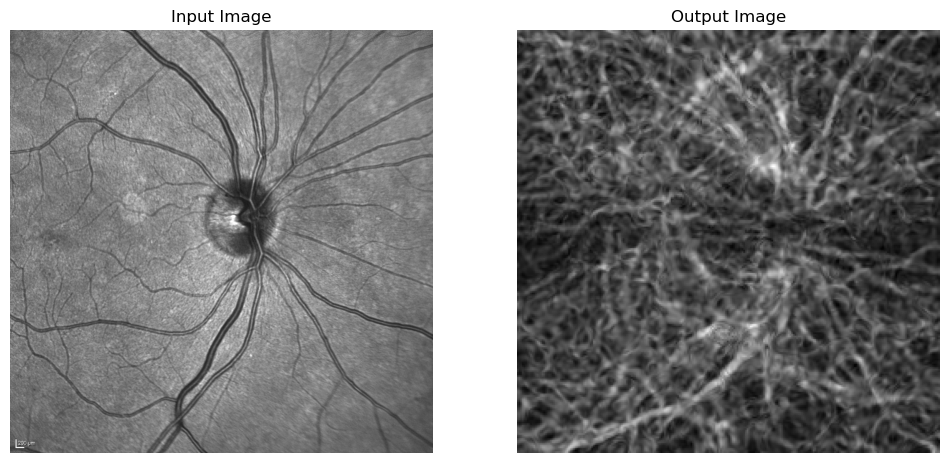

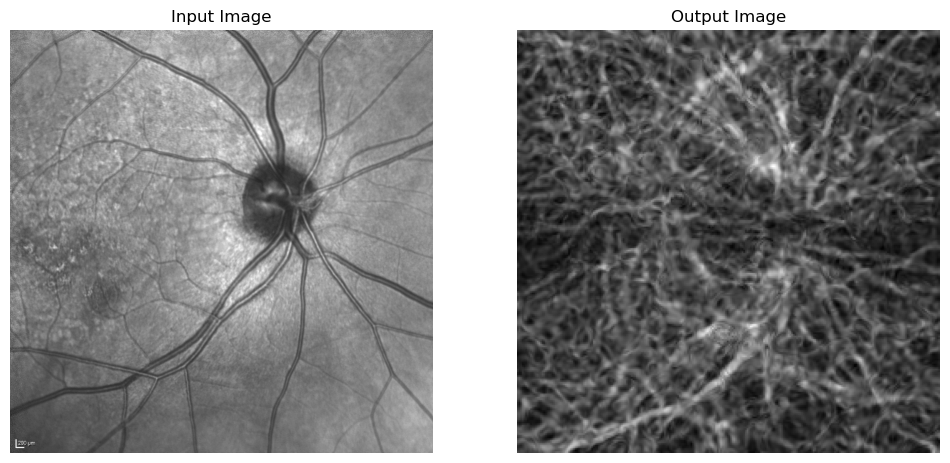

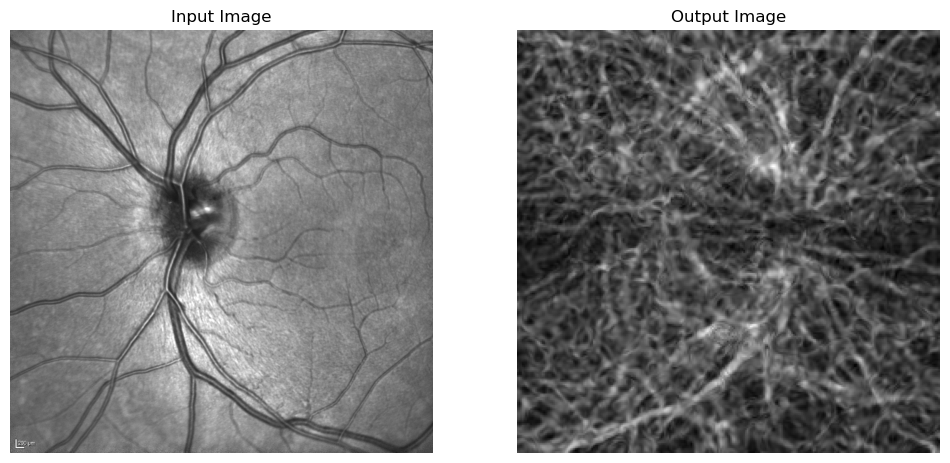

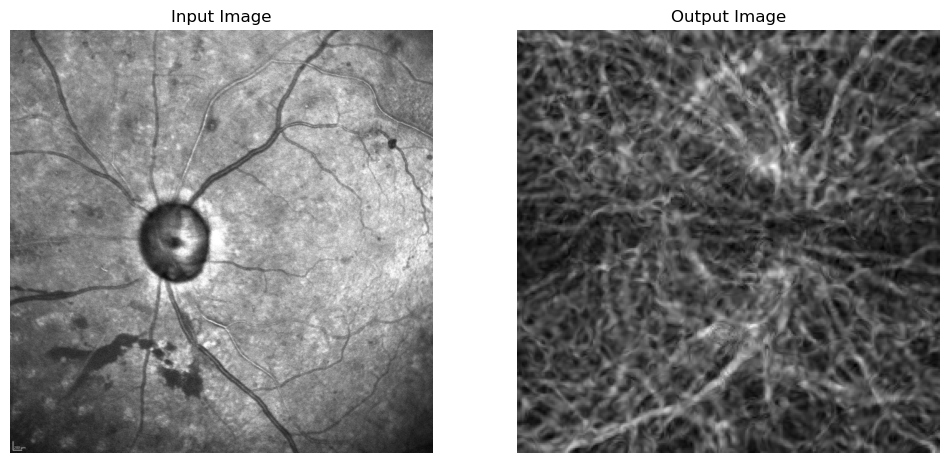

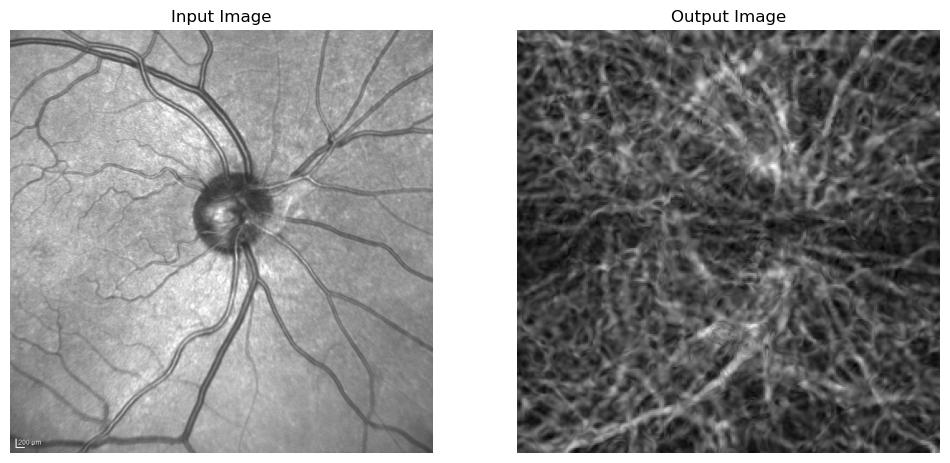

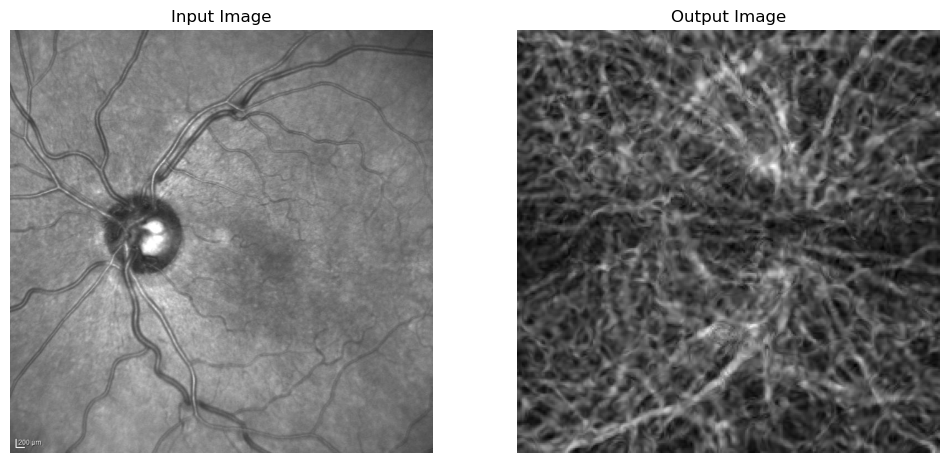

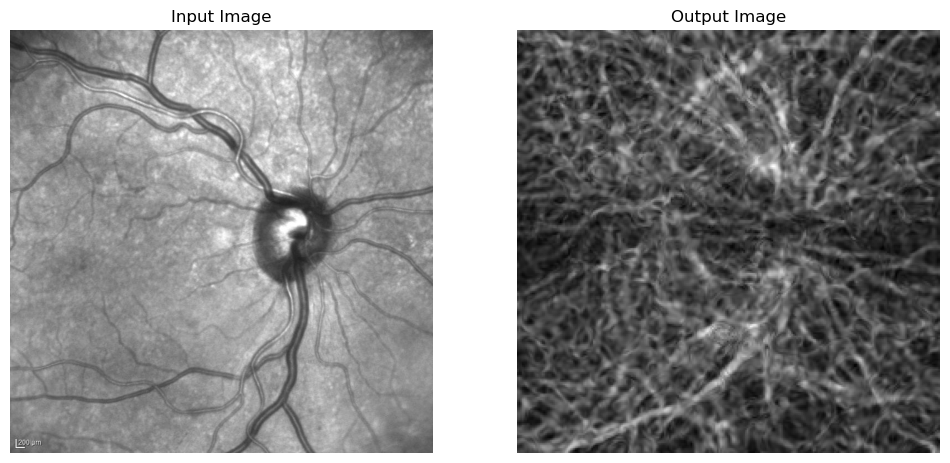

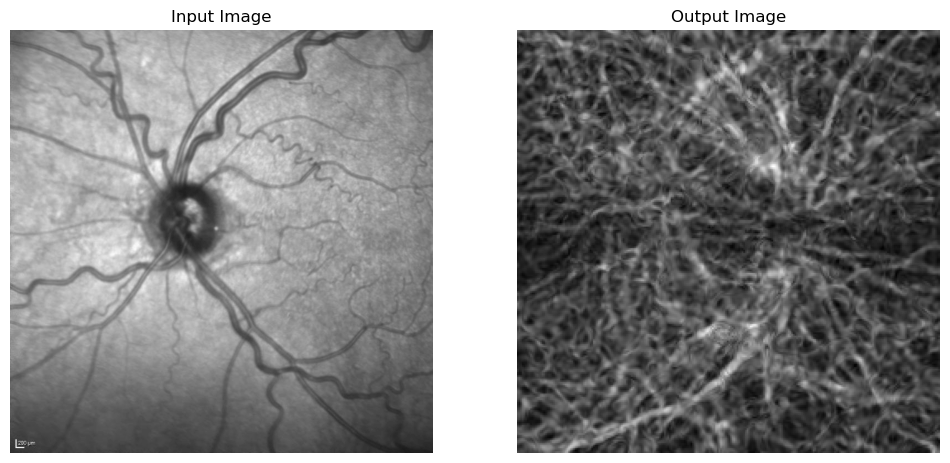

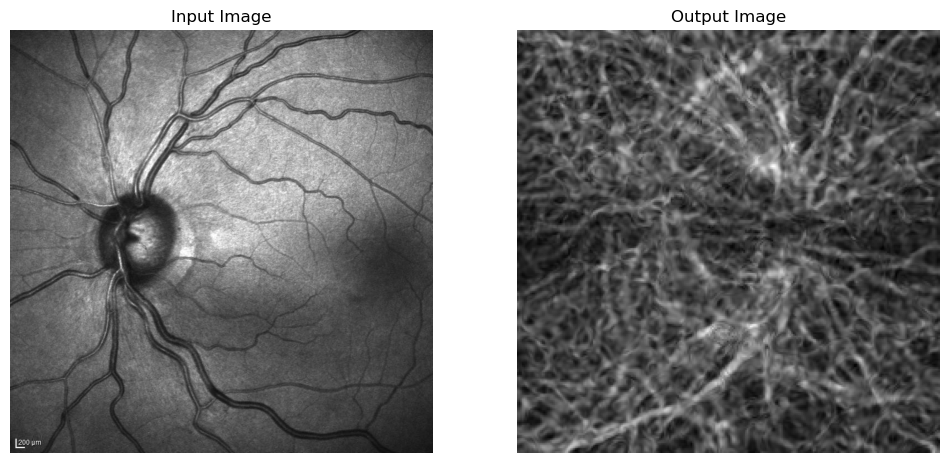

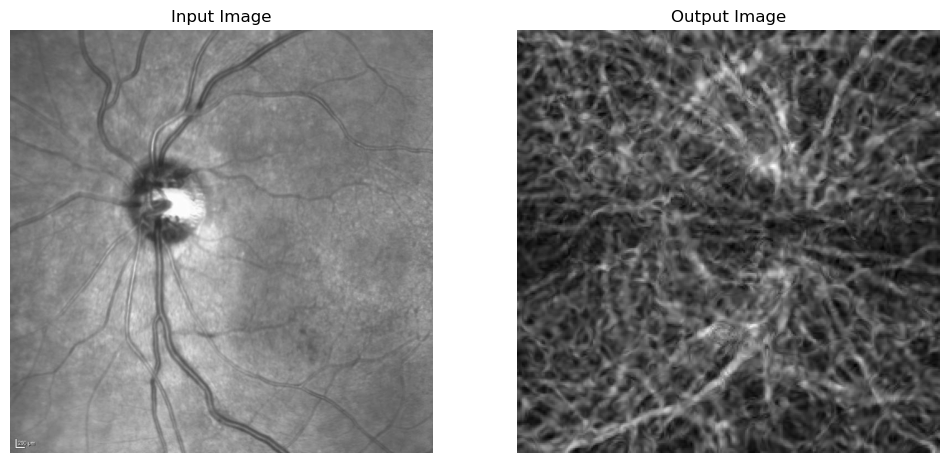

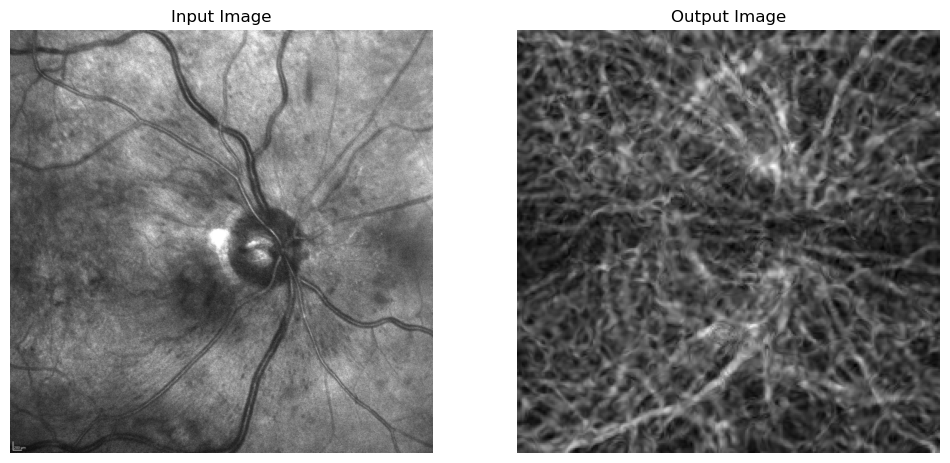

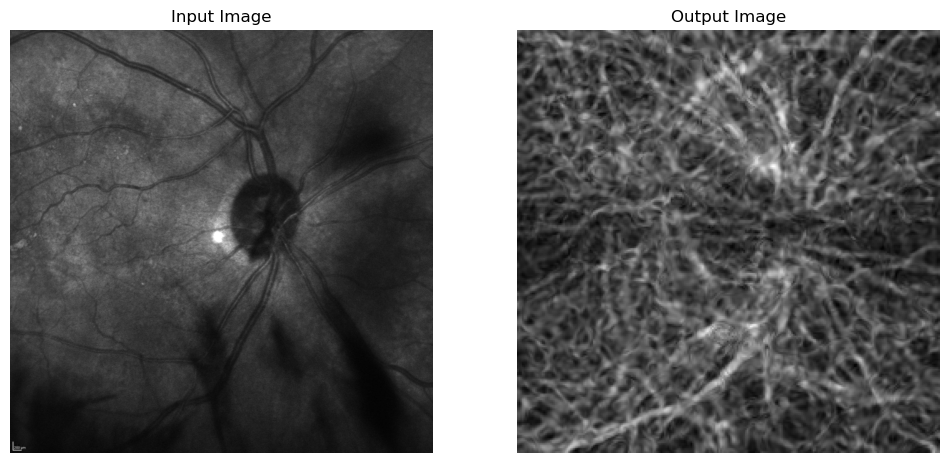

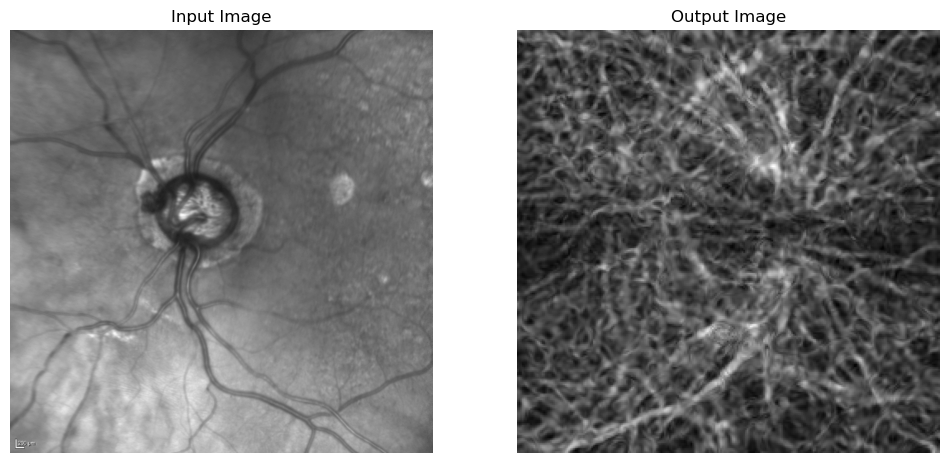

In [8]:
import torch
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from PIL import Image
import os
import matplotlib.pyplot as plt

# Carica il modello
model = Siren(in_features=2, hidden_features=192, hidden_layers=3, out_features=1)
model.load_state_dict(torch.load('retina_segmentation_model.pth'))
model.eval()  # Set the model to evaluation mode
model.to(device)

# Funzione per processare e visualizzare le immagini
def process_and_visualize(test_path):
    transform = Compose([
        Resize((256, 256)),
        ToTensor(),
        Normalize(mean=[0.5], std=[0.5])
    ])

    images = os.listdir(test_path)
    for img_name in images:
        img_path = os.path.join(test_path, img_name)
        image = Image.open(img_path).convert('L')
        image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
        
        coords = np.meshgrid(np.linspace(-1, 1, image_tensor.shape[3]), np.linspace(-1, 1, image_tensor.shape[2]))
        coords = np.stack(coords, axis=-1)
        coords = torch.FloatTensor(coords).to(device)
        coords = coords.view(1, -1, 2)  # [1, H*W, 2]

        with torch.no_grad():
            output = model(coords)
            output = output.view(1, 256, 256)  # Reshape output to image shape

        # Visualizzazione delle immagini
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(image, cmap='gray')
        ax[0].set_title('Input Image')
        ax[0].axis('off')

        output_img = output.cpu().squeeze().numpy()
        ax[1].imshow(output_img, cmap='gray')
        ax[1].set_title('Output Image')
        ax[1].axis('off')

        plt.show()

# Chiamata alla funzione con il percorso di test
process_and_visualize(test_input)


In [9]:
# from PIL import Image
# import os

# def analyze_image(image_path):
#     # Carica l'immagine usando Pillow
#     with Image.open(image_path) as img:
#         # Mostra l'immagine

#         # Ottieni le dimensioni dell'immagine
#         width, height = img.size
#         print(f"Dimensions: {width}x{height} pixels")

#         # Conta i canali di colore
#         mode = img.mode
#         print(f"Color mode: {mode}")
        
#         # Calcola il rapporto di aspetto
#         aspect_ratio = width / height
#         print(f"Aspect Ratio: {aspect_ratio:.2f}")

#         # Mostra la profondità di bit (basato sul tipo di mode)
#         if mode == "1":
#             depth = 1
#         elif mode == "L" or mode == "P":
#             depth = 8
#         elif mode == "RGB" or mode == "YCbCr":
#             depth = 8 * 3
#         elif mode == "RGBA" or mode == "CMYK":
#             depth = 8 * 4
#         else:
#             depth = "Unknown"
        
#         print(f"Bit Depth per Channel: {depth}")

#         # Calcola e mostra la dimensione del file
#         file_size = os.path.getsize(image_path)
#         print(f"File Size: {file_size} bytes")

# # Utilizzo della funzione
# image_path = 'C:/Users/Q540900/Desktop/A.I. Master/Werkstudent/RAVIR Dataset/train/training_images/IR_Case_011.png'
# analyze_image(image_path)


: 

In [ ]:
# Including also intensiti in the code
# --> coordinates pixel + intensity
# --> cords+intensity input --> cords + intersity mask
# 1 sinlayer + fully connected layers that takes the positional encoding and the intensity 